In [1]:
# Here we take care of paths.

from pathlib import Path
import os
print('Starting path:' + os.getcwd())
if os.getcwd()[-16:] == 'image-to-tex-OCR':
    pass
else:
    PATH = Path().resolve().parents[0]
    os.chdir(PATH)

# make sure you are in Paragraph_to_Tex folder
print('Current path:' + os.getcwd())

Starting path:/Users/gregory/PROJECT_ML/PROJECT_AMINE/image-to-tex-OCR/Jupyter_Notebooks
Current path:/Users/gregory/PROJECT_ML/PROJECT_AMINE/image-to-tex-OCR


In [2]:
from Data.Data_Module import Data_Module
from Models.Printed_Tex_Transformer import ResNetTransformer
from Lightning_Models.Printed_Tex_Lit_Model import LitResNetTransformer
import numpy as np
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from PIL import Image
import torch
from pytorch_lightning.loggers import TensorBoardLogger
from torchvision import transforms
from PIL import Image
from IPython.display import display, Math
from Data.image_transforms import Image_Transforms
import cv2
import cv2
import PIL
import numpy as np
transform = transforms.ToPILImage()


dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")


In [3]:
# Generate Data Module by uploading images and formulas
# images need to be in the folder Data/Data_Bank/generated_png_images
# formulas need to be in Data/Data_Bank/final_png_formulas.txt
# image filenames need to be in Data/Data_Bank/corresponding_png_images.txt

dataset = Data_Module(stage = 'fit',
                 set_max_label_length = 128,
                 number_png_images_to_use_in_dataset=250*1000,
                 labels_transform='default',
                image_transform_name ='alb',
                 train_val_fraction = 0.999,
                   vocabulary_path = 'Data/Data_Bank/230k.json',
                load_vocabulary = True,
                      image_padding = True,


                 batch_size = 128,
                num_workers = 8,
                data_on_gpu = True,
                )


In [4]:
print( 
    'Vocabulary size:',len(dataset.vocabulary),
    '\nMax label length:', dataset.max_label_length,
    "\nStart <S> goes to index ",dataset.vocabulary['<S>'],
      "\nEnd <E> goes to index ",dataset.vocabulary['<E>'],
      "\nPadding <P> goes to index ",dataset.vocabulary['<P>'],
)

Vocabulary size: 579 
Max label length: 130 
Start <S> goes to index  0 
End <E> goes to index  1 
Padding <P> goes to index  2


In [5]:
# HELPER FUNCTIONS
def token_to_strings(tokens):
    mapping = dataset.vocabulary
    inverse_mapping =dataset.inverse_vocabulary
    s=''
    if tokens.shape[0] ==1:
        tokens = tokens[0]
    for number in tokens:
        letter = inverse_mapping[number.item()]
        s= s +" " + str(letter)
    return s
def findPositions(image):
    positions = np.nonzero(image)
    top = positions[0].min()
    bottom = positions[0].max()
    left = positions[1].min()
    right = positions[1].max()
    image = cv2.rectangle(image, (left-2, top-2), (right+2, bottom+2), (0, 0, 0), 0)
    return image



In [6]:
# Load with lightining
#model = ResNetTransformer(dataset=dataset).to(dev)
#lit_model = LitResNetTransformer(model=model, WandB=False)

#lit_model = lit_model.load_from_checkpoint("Models_Parameters_Log/epoch=4-step=17280.ckpt")
#scripted = lit_model.to_torchscript()

In [7]:
# Load with pytorch epoch=4-step=17280.ckpt

model = ResNetTransformer(dataset=dataset).to(dev)
model.load_state_dict(torch.load(("Models_Parameters_Log/Printed2_2D600_350_pre.pth"), map_location=torch.device('cpu')))
lit_model = LitResNetTransformer(model=model, WandB=False)
scripted = lit_model.to_torchscript()


/Users/gregory/opt/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/gregory/opt/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/Users/gregory/opt/anaconda3/lib/python3.9/site-packages/torch/jit/_recursive.py:262: UserWarning: 'batch_first' was found in ScriptModule constants, but was not actually set in __init__. Consider removing it.
  warnings.warn("'{}' was found in ScriptModule constants, "


In [8]:
import cv2
import numpy as np
from PIL import Image

IMAGE_SIZE = 1800
BINARY_THREHOLD = 180

def process_image_for_ocr(file_path):
    # TODO : Implement using opencv
    temp_filename = set_image_dpi(file_path)
    im_new = remove_noise_and_smooth(temp_filename)
    return im_new

def set_image_dpi(file_path):
    im = Image.open(file_path)
    length_x, width_y = im.size
    factor = max(1, int(IMAGE_SIZE / length_x))
    size = factor * length_x, factor * width_y
    # size = (1800, 1800)
    im_resized = im.resize(size, Image.ANTIALIAS)
    temp_file = tempfile.NamedTemporaryFile(delete=False, suffix='.jpg')
    temp_filename = temp_file.name
    im_resized.save(temp_filename, dpi=(300, 300))
    return temp_filename

def image_smoothening(img):
    ret1, th1 = cv2.threshold(img, BINARY_THREHOLD, 255, cv2.THRESH_BINARY)
    ret2, th2 = cv2.threshold(th1, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    blur = cv2.GaussianBlur(th2, (1, 1), 0)
    ret3, th3 = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return th3


(800, 32)


/var/folders/wc/60y8v25x3ns_jgsx6clbdb180000gn/T/ipykernel_32970/3840194321.py:19: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
  img_resize = image.resize((w_new, h_new), Image.BILINEAR)


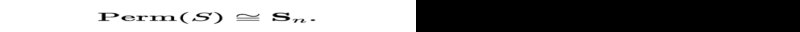

None


In [9]:
MAX_RATIO = 25

# Resize images with roughly the same aspect ratio
# Resize height to 32 times the original, and width with roughly the same ratio but it must be divisible by 32




image_path= "Jupyter_Notebooks/test_photos/zarhin.png"
image = Image.open(image_path).convert('RGB')
w, h = image.size
ratio = round((w / h) * 3) 
if ratio == 0:
    ratio = 1 
if ratio > MAX_RATIO:
    ratio = MAX_RATIO
h_new = 32
w_new = h_new * ratio
img_resize = image.resize((w_new, h_new), Image.BILINEAR)

# Do padding to the right half of the image so that the ratio remain fixed as self.max_ratio
img_padd = Image.new('RGB', (32*MAX_RATIO, 32), (0,0,0))
img_padd.paste(img_resize, (0, 0)) 
print(img_padd.size)
print(display(img_padd))


(800, 32)


/var/folders/wc/60y8v25x3ns_jgsx6clbdb180000gn/T/ipykernel_32970/793948986.py:11: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
  img_resize = image.resize((w_new, h_new), Image.BILINEAR)


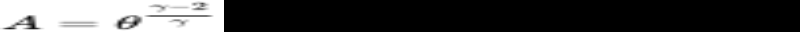

None


In [10]:
image_path= "Jupyter_Notebooks/test_photos/0a0ebebfb1f6ab3.png"
image = Image.open(image_path).convert('RGB')
w, h = image.size
ratio = round((w / h) * 3) 
if ratio == 0:
    ratio = 1 
if ratio > MAX_RATIO:
    ratio = MAX_RATIO
h_new = 32
w_new = h_new * ratio
img_resize = image.resize((w_new, h_new), Image.BILINEAR)

# Do padding to the right half of the image so that the ratio remain fixed as self.max_ratio
img_padd = Image.new('RGB', (32*MAX_RATIO, 32), (0,0,0))
img_padd.paste(img_resize, (0, 0)) 
print(img_padd.size)
print(display(img_padd))

(800, 32)


/var/folders/wc/60y8v25x3ns_jgsx6clbdb180000gn/T/ipykernel_32970/1307951978.py:11: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
  img_resize = image.resize((w_new, h_new), Image.BILINEAR)


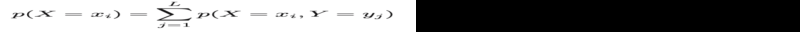

None


In [11]:
image_path= "Jupyter_Notebooks/test_photos/screenshot_1.png"
image = Image.open(image_path).convert('RGB')
w, h = image.size
ratio = round((w / h) * 3) 
if ratio == 0:
    ratio = 1 
if ratio > MAX_RATIO:
    ratio = MAX_RATIO
h_new = 32
w_new = h_new * ratio
img_resize = image.resize((w_new, h_new), Image.BILINEAR)

# Do padding to the right half of the image so that the ratio remain fixed as self.max_ratio
img_padd = Image.new('RGB', (32*MAX_RATIO, 32), (0,0,0))
img_padd.paste(img_resize, (0, 0)) 
print(img_padd.size)
print(display(img_padd))

(800, 32)


/var/folders/wc/60y8v25x3ns_jgsx6clbdb180000gn/T/ipykernel_32970/1307951978.py:11: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
  img_resize = image.resize((w_new, h_new), Image.BILINEAR)


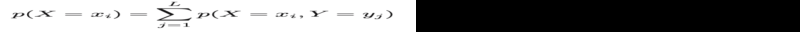

None


In [12]:
image_path= "Jupyter_Notebooks/test_photos/screenshot_1.png"
image = Image.open(image_path).convert('RGB')
w, h = image.size
ratio = round((w / h) * 3) 
if ratio == 0:
    ratio = 1 
if ratio > MAX_RATIO:
    ratio = MAX_RATIO
h_new = 32
w_new = h_new * ratio
img_resize = image.resize((w_new, h_new), Image.BILINEAR)

# Do padding to the right half of the image so that the ratio remain fixed as self.max_ratio
img_padd = Image.new('RGB', (32*MAX_RATIO, 32), (0,0,0))
img_padd.paste(img_resize, (0, 0)) 
print(img_padd.size)
print(display(img_padd))

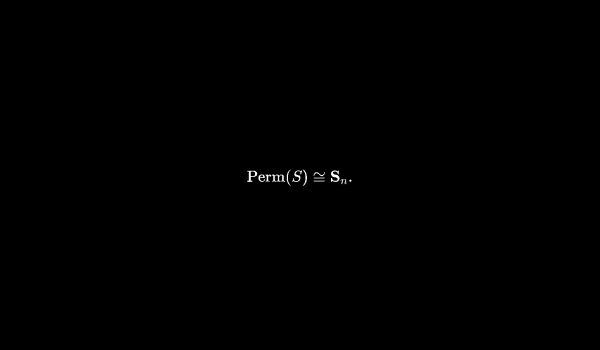

None

Predicted formula:
 <S> \qquad \qquad \mathrm { P e r m } ( S ) \approx \mathrm { S } _ { n } . \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None


In [13]:
## ALB

image_path= "Jupyter_Notebooks/test_photos/zarhin.png"

image = Image.open(image_path).convert('RGB')
image = np.asarray(image)
image = cv2.bitwise_not(image)
image = findPositions(image)
h, w, c = image.shape
aspect = h / w

image = findPositions(image)

# Thresholding
if w > 200:
    ret, image = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY)

# Downscaling big images
new_w = 200
new_h = int(new_w * aspect)
if w>500:
    image = cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_AREA)
else:
    image = cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_CUBIC)

    

image_tensor = Image_Transforms.test_transform_with_padding_xs(image=np.array(image))['image'][:1]    
    
    
    
print(display(transform(image_tensor)))



#prediction =  scripted_model(my_image_tensor.unsqueeze(0).to(dev))
print('\nPredicted formula:')
prediction =  scripted(image_tensor.unsqueeze(0))
print(token_to_strings(prediction))
print(display(Math(token_to_strings(prediction))))


152 658 0.23100303951367782


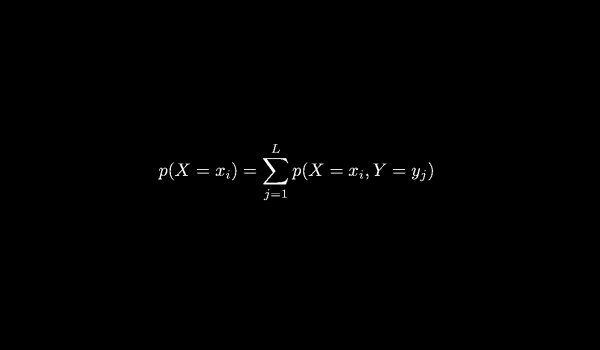

None

Predicted formula:
 <S> \qquad \qquad \qquad \qquad \qquad P ( X = x _ { i } ) = \sum _ { y = 1 } ^ { L } p ( X = x _ { i } , Y = y _ { j } ) \qquad \qquad \qquad \qquad \qquad <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None


In [14]:
## ALB

image_path= "Jupyter_Notebooks/test_photos/screenshot_1.png"

image = Image.open(image_path).convert('RGB')
image = np.asarray(image)
image = cv2.bitwise_not(image)
image = findPositions(image)
h, w, c = image.shape

aspect = h / w
print(h,w, aspect)

image = findPositions(image)

# Thresholding
if w > 400:
    ret, image = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY)


# Downscaling big images
new_w = 300
new_h = int(new_w * aspect)
if w>500:
    image = cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_AREA)
else:
    image = cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_CUBIC)

    

image_tensor = Image_Transforms.test_transform_with_padding_xs(image=np.array(image))['image'][:1]    
    

print(display(transform(image_tensor)))



#prediction =  scripted_model(my_image_tensor.unsqueeze(0).to(dev))
print('\nPredicted formula:')
prediction =  scripted(image_tensor.unsqueeze(0))
print(token_to_strings(prediction))
print(display(Math(token_to_strings(prediction))))


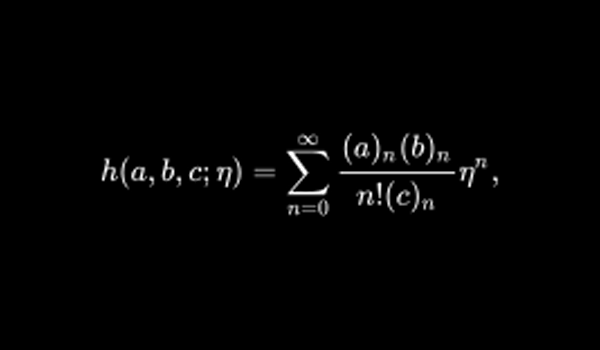

None

Predicted formula:
 <S> h ( a , b , c ; \eta ) = \sum _ { n = 0 } ^ { \infty } \frac { ( a ) _ { n } ( b ) _ { n } } { n ! ( c ) _ { n } } \eta ^ { n } , <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None


In [15]:
## ALB

image_path= "Jupyter_Notebooks/test_photos/0a0df4c4229b725.png"

image = Image.open(image_path).convert('RGB')
image = np.asarray(image)
image = cv2.bitwise_not(image)
image = findPositions(image)
h, w, c = image.shape
aspect = h / w

image = findPositions(image)

# Thresholding
if w > 400:
    ret, image = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY)


# Downscaling big images
new_w = 400
new_h = int(new_w * aspect)
if w>500:
    image = cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_AREA)
else:
    image = cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_CUBIC)

    

image_tensor = Image_Transforms.test_transform_with_padding_xs(image=np.array(image))['image'][:1]    
    
    
print(display(transform(image_tensor)))



#prediction =  scripted_model(my_image_tensor.unsqueeze(0).to(dev))
print('\nPredicted formula:')
prediction =  scripted(image_tensor.unsqueeze(0))
print(token_to_strings(prediction))
print(display(Math(token_to_strings(prediction))))

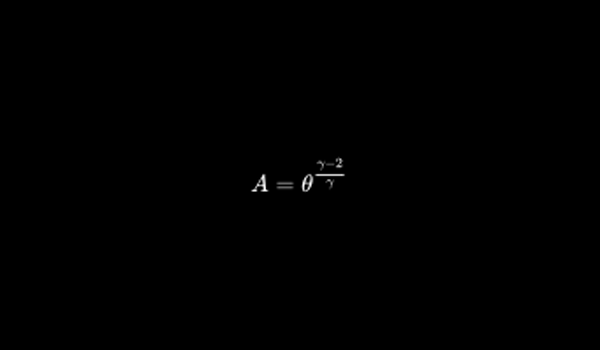

None

Predicted formula:
 <S> \qquad \qquad A = \theta ^ { \frac { \gamma - 2 } { \gamma } } \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None


In [16]:
## ALB

image_path= "Jupyter_Notebooks/test_photos/0a0ebebfb1f6ab3.png"

image = Image.open(image_path).convert('RGB')
image = np.asarray(image)
image = cv2.bitwise_not(image)
image = findPositions(image)
h, w, c = image.shape
aspect = h / w

image = findPositions(image)


# Downscaling big images
new_w = 100
new_h = int(new_w * aspect)
if w>500:
    image = cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_AREA)
else:
    image = cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_CUBIC)

    

image_tensor = Image_Transforms.test_transform_with_padding_xs(image=np.array(image))['image'][:1]    
    
    
print(display(transform(image_tensor)))



#prediction =  scripted_model(my_image_tensor.unsqueeze(0).to(dev))
print('\nPredicted formula:')
prediction =  scripted(image_tensor.unsqueeze(0))
print(token_to_strings(prediction))
print(display(Math(token_to_strings(prediction))))

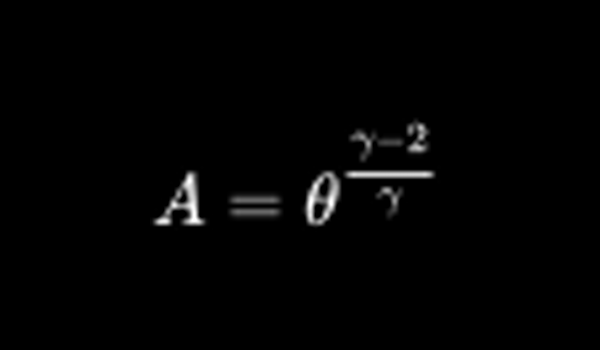

None

Predicted formula:
 <S> \begin{array} { c c c c c c c c c } { A = \theta ^ { \frac { \gamma - 2 } { \gamma } } & { } & { } & { } & { } & { } & { } & { } & { } & { } & { } & { } & { } & { } & { } & { } & { } & { } & { } & { } & { } & { } & { } & { } & { } & { } & { } & { } & { } & { } & { } & { } & { } & { } & {


<IPython.core.display.Math object>

None


In [17]:
## ALB

image_path= "Jupyter_Notebooks/test_photos/0a0ebebfb1f6ab3.png"

image = Image.open(image_path).convert('RGB')
image = np.asarray(image)
image = cv2.bitwise_not(image)
image = findPositions(image)
h, w, c = image.shape
aspect = h / w

image = findPositions(image)

# Thresholding
if w > 400:
    ret, image = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY)

# Downscaling big images
if w > 600:
    new_w = 600
    new_h = int(new_w * aspect)
    image = cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_AREA)


if w<200:
    image_tensor = Image_Transforms.test_transform_with_padding_xss(image=np.array(image))['image'][:1]
elif w < 350:
    image_tensor = Image_Transforms.test_transform_with_padding_small(image=np.array(image))['image'][:1]
elif w<600:
    image_tensor = Image_Transforms.test_transform_with_padding(image=np.array(image))['image'][:1]
else:
    image_tensor = Image_Transforms.test_transform_with_padding_xl(image=np.array(image))['image'][:1]
    

    
print(display(transform(image_tensor)))



#prediction =  scripted_model(my_image_tensor.unsqueeze(0).to(dev))
print('\nPredicted formula:')
prediction =  scripted(image_tensor.unsqueeze(0))
print(token_to_strings(prediction))
print(display(Math(token_to_strings(prediction))))

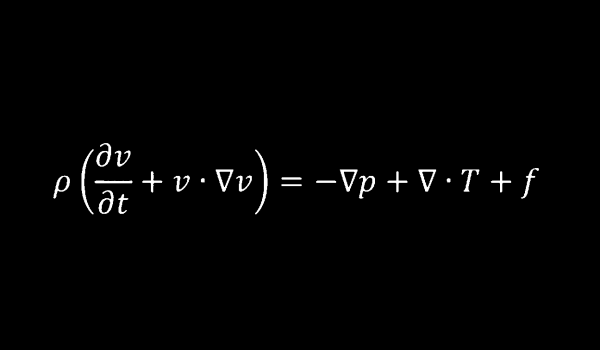

None

Predicted formula:
 <S> \rho \left( \frac { \partial \, { \cal V } } { \partial t } : \, { \cal V } \, { \cal V } \, { \cal V } \, { \cal V } \, { \cal V } \right) { \cal I } \, { \cal D } \, + \, \nabla \, { \cal I } \, + \, f <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None


In [18]:
## ALB

image_path= "Jupyter_Notebooks/test_photos/screenshot_3.png"

image = Image.open(image_path).convert('RGB')
image = np.asarray(image)
image = cv2.bitwise_not(image)
image = findPositions(image)
h, w, c = image.shape
aspect = h / w

image = findPositions(image)

# Thresholding
if w > 400:
    ret, image = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY)


# Downscaling big images
new_w = 500
new_h = int(new_w * aspect)
if w>500:
    image = cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_AREA)
else:
    image = cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_CUBIC)

    

image_tensor = Image_Transforms.test_transform_with_padding_xs(image=np.array(image))['image'][:1]    
       

print(display(transform(image_tensor)))



#prediction =  scripted_model(my_image_tensor.unsqueeze(0).to(dev))
print('\nPredicted formula:')
prediction =  scripted(image_tensor.unsqueeze(0))
print(token_to_strings(prediction))
print(display(Math(token_to_strings(prediction))))

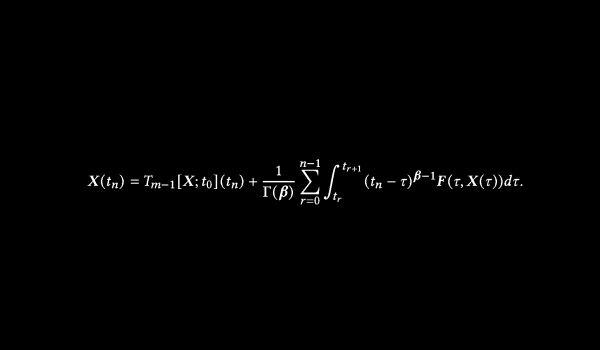

None

Predicted formula:
 <S> X ( t _ { n } ) \, \pm \, T _ { m - 1 } [ X ; q _ { n } \} ( t _ { n } ) \, ; \frac { 1 } { \Gamma ( g ) } \sum _ { r = 0 } ^ { n - 1 } \int _ { t } ^ { t _ { r } } ^ { t _ { n } } ( t _ { n } - \tau ) ^ { \theta - 1 } F ( \tau , X ( \tau ) d \tau . <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None


In [19]:
## ALB

image_path= "Jupyter_Notebooks/test_photos/Screen Shot_14.png"

image = Image.open(image_path).convert('RGB')
image = np.asarray(image)
image = cv2.bitwise_not(image)
image = findPositions(image)
h, w, c = image.shape
aspect = h / w

image = findPositions(image)

# Thresholding
if w > 400:
    ret, image = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY)


# Downscaling big images
new_w = 500
new_h = int(new_w * aspect)
if w>500:
    image = cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_AREA)
else:
    image = cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_CUBIC)

    

image_tensor = Image_Transforms.test_transform_with_padding_xs(image=np.array(image))['image'][:1]    
    
#image_tensor = Image_Transforms.test_transform_with_padding_medium(image=np.array(image))['image'][:1]    

print(display(transform(image_tensor)))



#prediction =  scripted_model(my_image_tensor.unsqueeze(0).to(dev))
print('\nPredicted formula:')
prediction =  scripted(image_tensor.unsqueeze(0))
print(token_to_strings(prediction))
print(display(Math(token_to_strings(prediction))))

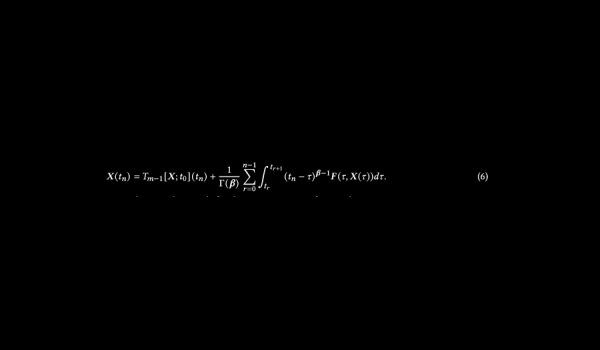

None

Predicted formula:
 <S> X _ { ( a ) \cdot T _ { m + l , N _ { m } | ( w ) } , \cdot \frac { 1 } { 5 / ( w ) } \frac { 1 } { 5 / ( g ) } \sum _ { 2 } ^ { n _ { \mu } } ^ { n _ { \mu } } ( k - r , p ^ { \mu _ { t } } ( \xi , \chi ( \gamma ) d r } \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None


In [20]:
## ALB

image_path= "Jupyter_Notebooks/test_photos/Screen Shot_13.png"

image = Image.open(image_path).convert('RGB')
image = np.asarray(image)
image = cv2.bitwise_not(image)
image = findPositions(image)
h, w, c = image.shape
aspect = h / w

image = findPositions(image)

# Thresholding
if w > 400:
    ret, image = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY)

# Downscaling big images
if w > 600:
    new_w = 600
    new_h = int(new_w * aspect)
    image = cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_AREA)


if w<200:
    image_tensor = Image_Transforms.test_transform_with_padding_xs(image=np.array(image))['image'][:1]
elif w < 350:
    image_tensor = Image_Transforms.test_transform_with_padding_small(image=np.array(image))['image'][:1]
elif w<600:
    image_tensor = Image_Transforms.test_transform_with_padding(image=np.array(image))['image'][:1]
else:
    image_tensor = Image_Transforms.test_transform_with_padding_xl(image=np.array(image))['image'][:1]
    
    
    
print(display(transform(image_tensor)))



#prediction =  scripted_model(my_image_tensor.unsqueeze(0).to(dev))
print('\nPredicted formula:')
prediction =  scripted(image_tensor.unsqueeze(0))
print(token_to_strings(prediction))
print(display(Math(token_to_strings(prediction))))

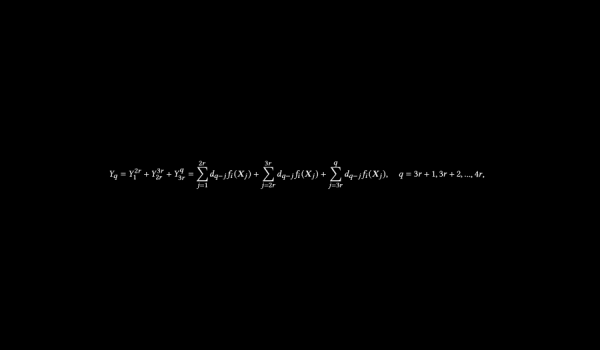

None

Predicted formula:
 <S> \begin{array} { c c c c c c c c c c c } { V _ { 0 } \cdot 1 ^ { 2 } \cdot 1 _ { 2 } ^ { 2 } \cdot 1 } & { } & { } & { } & { } & { } & { } & { } & { } & { } & { } & { } & { } & { } & { } & { } & { } & { } & { } & { } & { } & { } & { } & { } & { } & { } & { } & { } & { } & { } & { }


<IPython.core.display.Math object>

None


In [21]:
## ALB

image_path= "Jupyter_Notebooks/test_photos/Screen Shot_10.png"

image = Image.open(image_path).convert('RGB')
image = np.asarray(image)
image = cv2.bitwise_not(image)
image = findPositions(image)
h, w, c = image.shape
aspect = h / w

image = findPositions(image)

# Thresholding
if w > 400:
    ret, image = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY)

# Downscaling big images
if w > 600:
    new_w = 600
    new_h = int(new_w * aspect)
    image = cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_AREA)


if w<200:
    image_tensor = Image_Transforms.test_transform_with_padding_xs(image=np.array(image))['image'][:1]
elif w < 350:
    image_tensor = Image_Transforms.test_transform_with_padding_small(image=np.array(image))['image'][:1]
elif w<600:
    image_tensor = Image_Transforms.test_transform_with_padding(image=np.array(image))['image'][:1]
else:
    image_tensor = Image_Transforms.test_transform_with_padding_xl(image=np.array(image))['image'][:1]
    
    
    
print(display(transform(image_tensor)))



#prediction =  scripted_model(my_image_tensor.unsqueeze(0).to(dev))
print('\nPredicted formula:')
prediction =  scripted(image_tensor.unsqueeze(0))
print(token_to_strings(prediction))
print(display(Math(token_to_strings(prediction))))

torch.Size([1, 64, 1600])


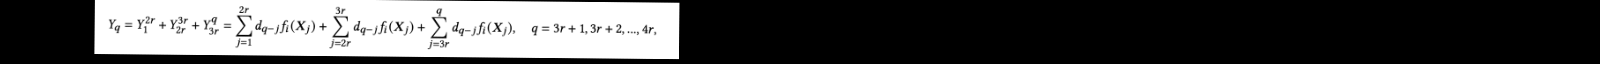

None


In [22]:

image_path= "Jupyter_Notebooks/test_photos/Screen Shot_10.png"
image = Image.open(image_path).convert('RGB')
image = np.asarray(image)

positions = np.nonzero(image)
top = positions[0].min()
bottom = positions[0].max()
left = positions[1].min()
right = positions[1].max()
image = cv2.rectangle(image, (left - 2, top - 2), (right + 2, bottom + 2), (0, 0, 0), 0)

h, w, c = image.shape
ratio = (w / h)
if ratio == 0:
    ratio = 1 
if ratio > MAX_RATIO:
    ratio = MAX_RATIO

new_h = 64
new_w = int(new_h * ratio)
if h >64:
    image = cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_AREA)
else:
    image = cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_CUBIC)

    
image_tensor = Image_Transforms.train_transform_with_padding(image=np.array(image))['image'][:1]
print(image_tensor.shape)
print(display(transform(image_tensor)))    


torch.Size([1, 64, 1600])


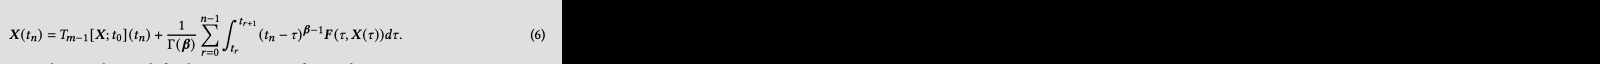

None


In [23]:

image_path= "Jupyter_Notebooks/test_photos/Screen Shot_13.png"
image = Image.open(image_path).convert('RGB')
image = np.asarray(image)

positions = np.nonzero(image)
top = positions[0].min()
bottom = positions[0].max()
left = positions[1].min()
right = positions[1].max()
image = cv2.rectangle(image, (left - 2, top - 2), (right + 2, bottom + 2), (0, 0, 0), 0)

h, w, c = image.shape
ratio =(w / h)
if ratio == 0:
    ratio = 1 
if ratio > MAX_RATIO:
    ratio = MAX_RATIO


new_h = 64
new_w = int(new_h * ratio)
if h >64:
    image = cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_AREA)
else:
    image = cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_CUBIC)


    
image_tensor = Image_Transforms.train_transform_with_padding(image=np.array(image))['image'][:1]
print(image_tensor.shape)
print(display(transform(image_tensor))) 